# FINAL PROJECT
### CSE 30124
### Evan Ackerman

### Loading in some initial libraries

In [16]:
# CSE 30124 MLB Contract Evaluator
# Evan Ackerman

# Importing Libraries
import builtins
import pandas as pd
import csv
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import random as rand

import seaborn

# Stats 2015-2022

Loading in the MLB Qualified Hitter Stats (502 PA) from the 2015-2022 seasons (except 2020 due to it being a shortened season). The data is from BaseballReference and BaseballSavant.

It was all compiled into `stats_2015_2022.csv` which is available in my GitHub repo. If the link to the GitHub raw download does not work, you can manually download it and upload it to the files folder on the lefthand side of the CoLab screen to make sure it is loaded into the runtime.

In [4]:
# Loading in the File
import os

# THIS CURRENT DATA IS QUALIFIED BATTERS FROM 2015 - 2022 (502 PA minimum)
if not os.path.exists('stats_2015_2022.csv'):
    !wget -c https://raw.githubusercontent.com/eackerm2/MLB-Contract-AI-ML-Project/main/stats_2015_2022.csv -O stats_2015_2022.csv

stats = pd.read_csv('stats_2015_2022.csv')

# display what stats we have
cols = []
for col in stats.columns:
    cols.append(col)
print(cols)

['last_name', 'first_name', 'player_id', 'year', 'player_age', 'hit', 'batting_avg', 'slg_percent', 'on_base_plus_slg', 'babip', 'xba', 'xslg', 'xobp', 'exit_velocity_avg', 'barrel_batted_rate', 'WAR', ' salary ']


# Adjusting Salaries for Inflation

Here the inflation rates from the years until 2022 were compiled from the Federal Reserve, and all salaries in the data set were adjusted to put everything into the Present Value in 2023.

In [5]:
# adjust the salaries that are in our data set to accound for inflation
INFLATION_CONVERSION = {
                            2015: 1.299,
                            2016: 1.282,
                            2017: 1.256,
                            2018: 1.226,
                            2019: 1.204,
                            2020: 1.189,
                            2021: 1.136,
                            2022: 1.052
                        }
million = 1000000
nSalaries = len(stats[' salary '])

salaries = list()
years = list()
for sal in stats[' salary ']:
    salaries.append(sal)

for y in stats['year']:
    years.append(y)

# Salaries Before Inflation
print(f'Average Salary before Inflation:')
avg = sum(salaries)/len(salaries)
print(f'${avg/million:.2f} Million')

for i in range(nSalaries):
    if years[i] in INFLATION_CONVERSION.keys():
        salaries[i] *= INFLATION_CONVERSION[years[i]]

# Salaries After Inflation
print(f'\nAverage Salary after Inflation:')
final_avg = sum(salaries)/len(salaries)
print(f'${final_avg/million:.2f} Million')

Average Salary before Inflation:
$7.86 Million

Average Salary after Inflation:
$9.48 Million


# Overarching View of Dataset

Here, all of the stats from the data are accessible and visible. I am most interested in how everything shapes up with player ages.

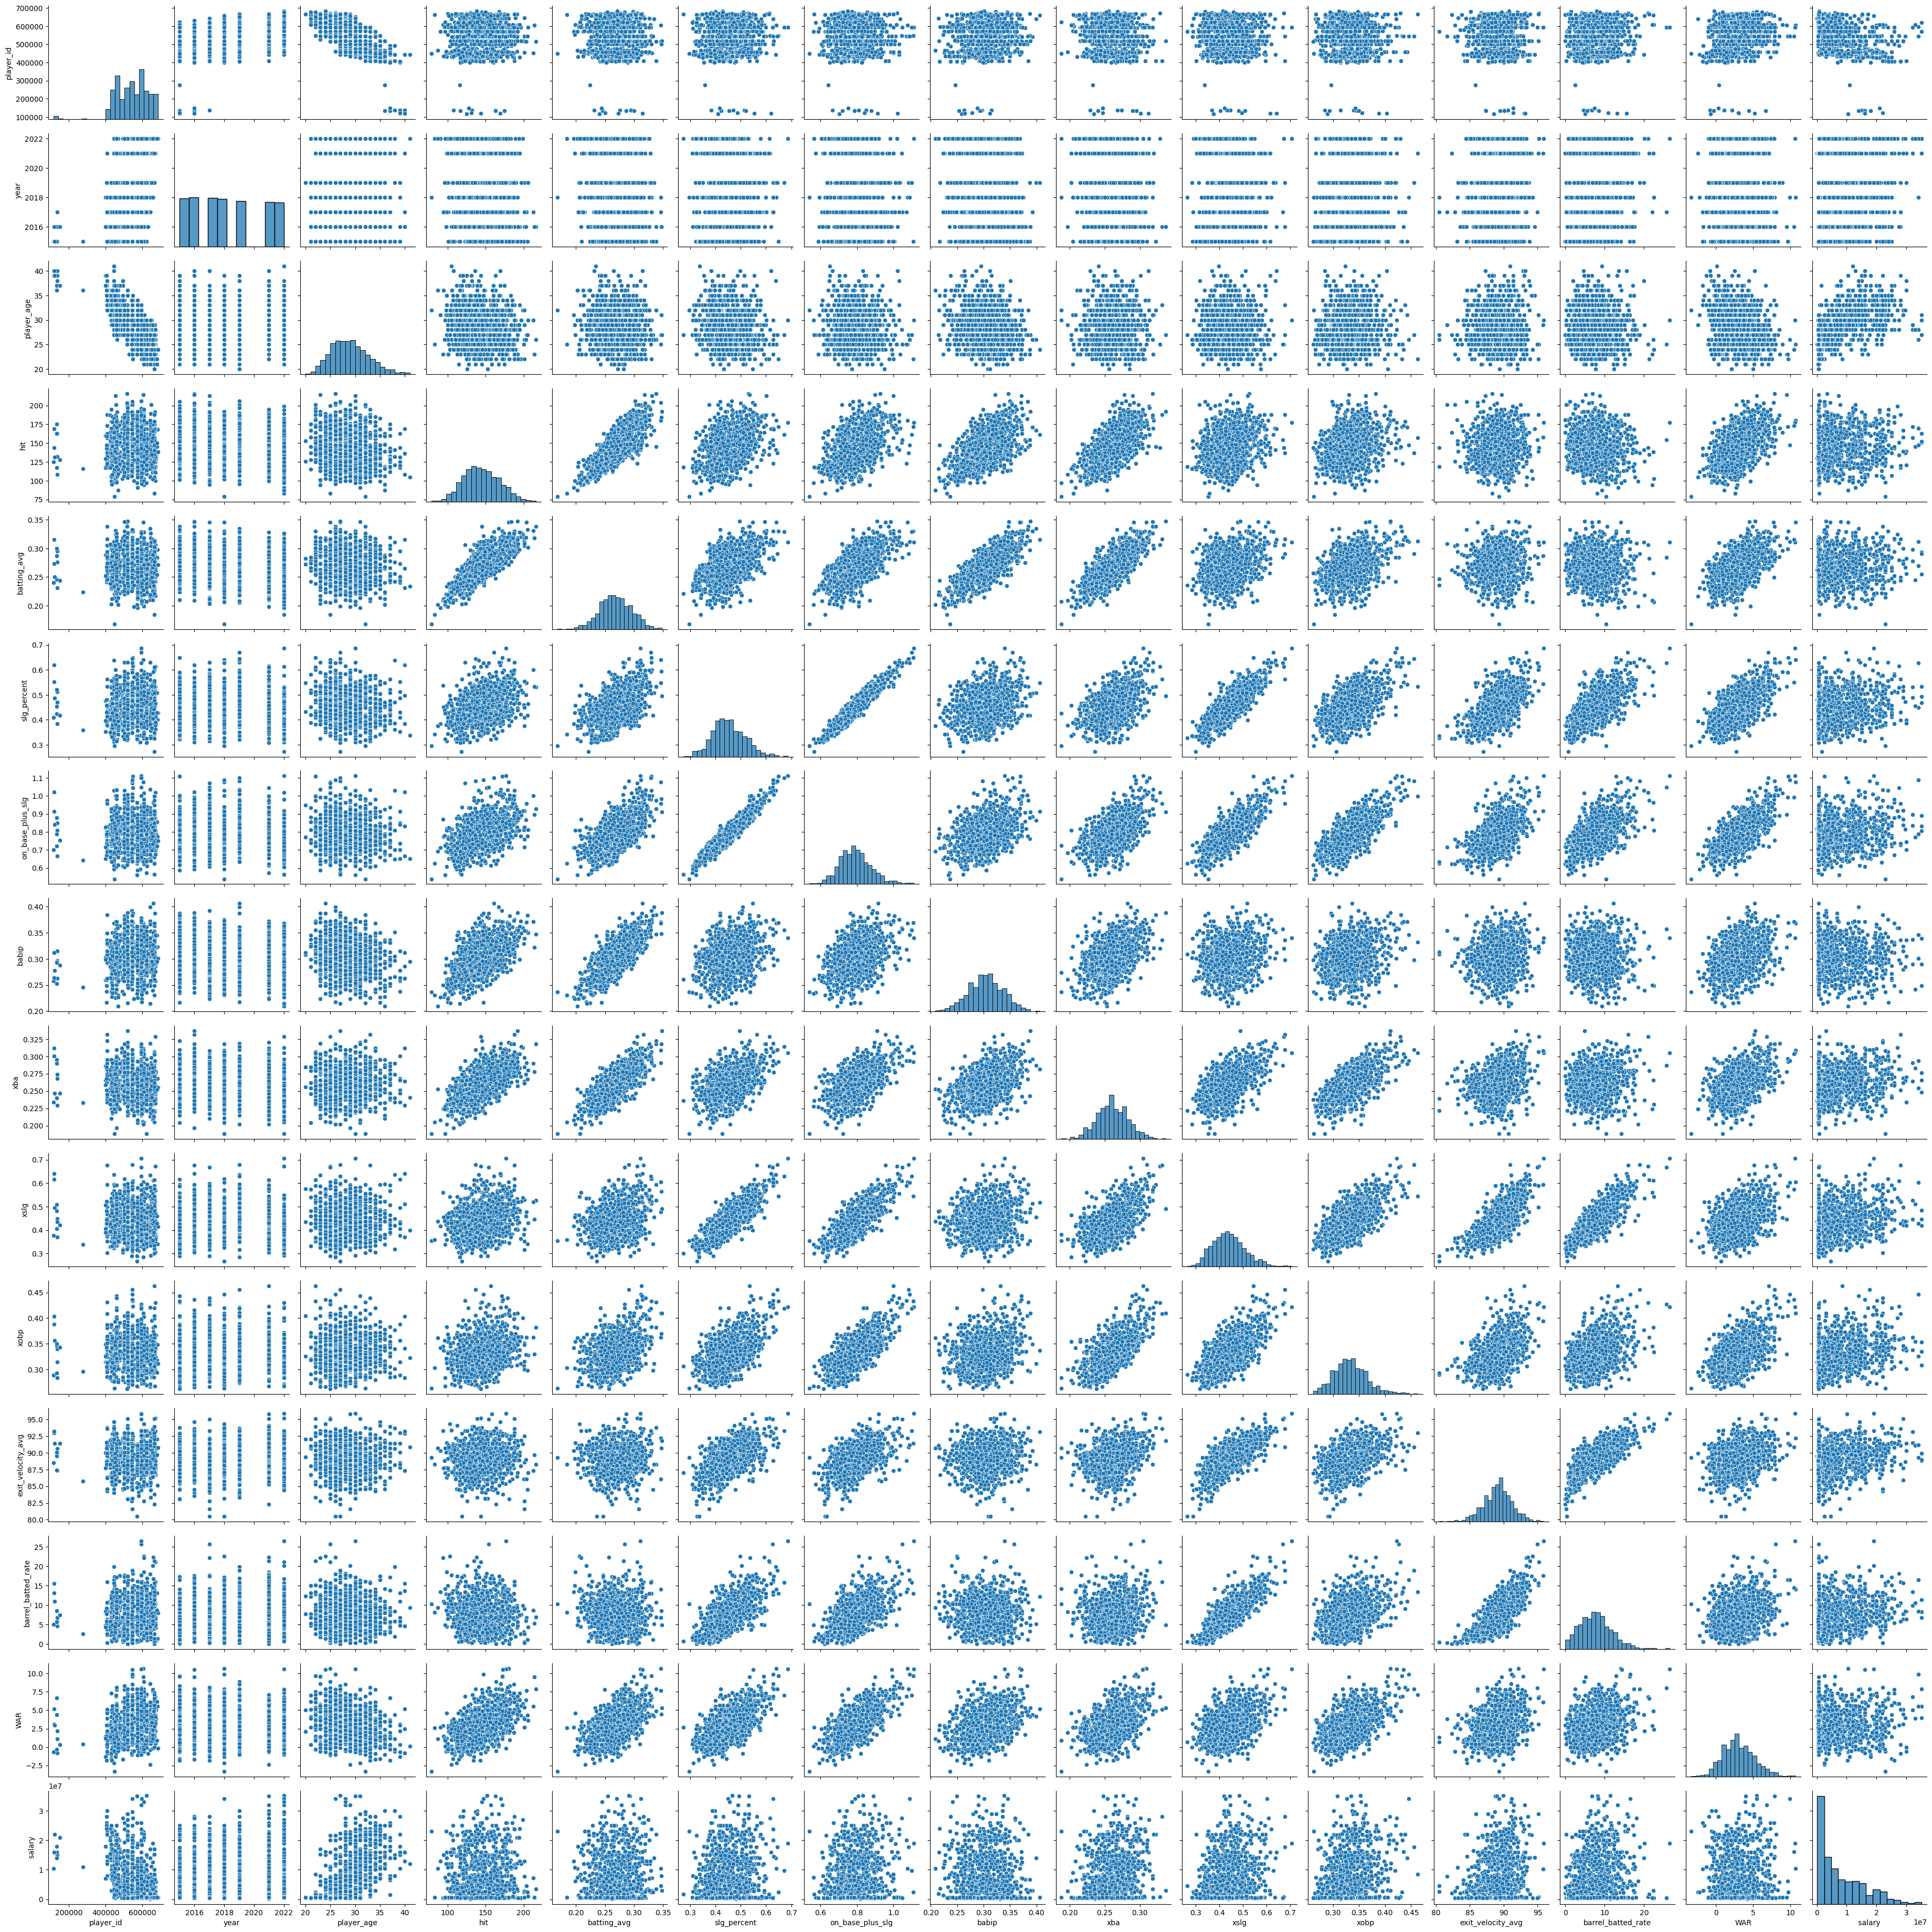

In [6]:
# Analysis of Stats Together
seaborn.pairplot(stats)

# Keying in on the `WAR` and `player_age` relationship

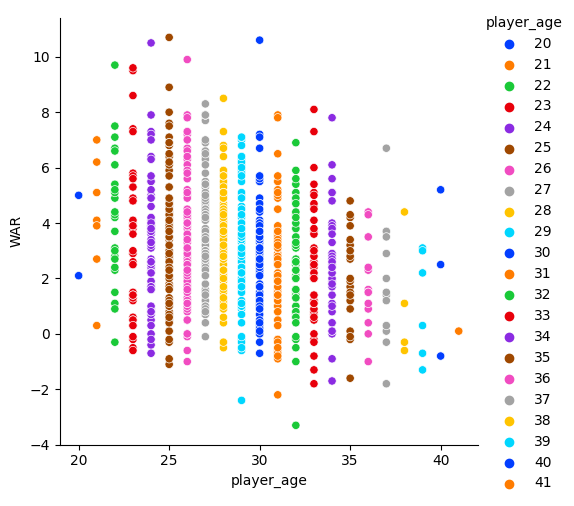

In [7]:
# Wow that's a large image, let's focus in!
pal = seaborn.color_palette("bright", 22)
seaborn.relplot(data=stats, x='player_age', y='WAR', hue='player_age', palette=pal)

# Breaking up data into Train and Test

In [8]:
from sklearn import linear_model
# Break up our data

# Getting our player ages and WARS
X = stats['player_age']
X = np.array(X).reshape(-1,1)
Y = stats['WAR']

# Now that we have the Ages
# TRAINING 75% TESTING 25%

poly = PolynomialFeatures()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
X_test = np.sort(X_test, axis=0)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Trying Linear Regression to Test if Data was broken up

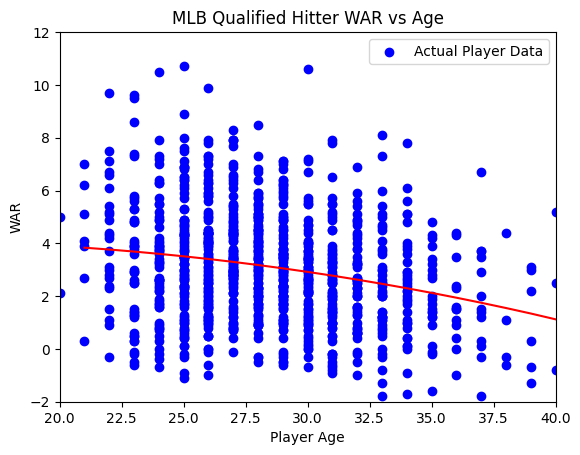

In [9]:
# Train the Linear Model
WAR_model = LinearRegression()
WAR_model.fit(X_poly_train,Y_train)

Y_pred = WAR_model.predict(X_poly_train)
Y_predTest = WAR_model.predict(X_poly_test)

# plot the results
plt.xlabel("Player Age")
plt.ylabel("WAR")
plt.title("MLB Qualified Hitter WAR vs Age")
plt.scatter(X, Y, color='b', label ="Actual Player Data")
plt.plot(X_test, Y_predTest, color="r")
plt.axis([20,40,-2,12])
plt.legend()
plt.show()

# not a good fit, try something else

# Implementation of Pipelining tool

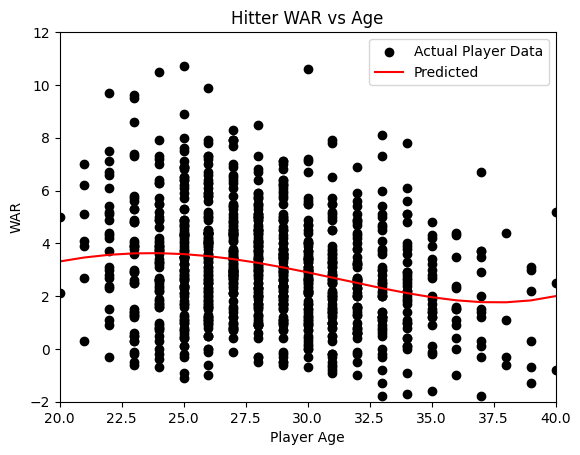

In [11]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
# Break up our data
# Getting our player ages and WARS
X = stats['player_age']
X = np.array(X).reshape(-1,1)
Y = stats['WAR']

# Now that we have the Ages
# TRAINING 75% TESTING 25%
# get all the data into training and testing that's actually usable
poly = PolynomialFeatures(degree=(2,4))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=110)
X_test = np.sort(X_test, axis=0)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Train the Model with pipeline feature to handle stuff under the hood
W = Pipeline([('poly', PolynomialFeatures(degree=(2,4))), ('linear', LinearRegression(fit_intercept=True))])
W.fit(X_train,Y_train)
Y_predTest = W.predict(X_test)

#plotting the results
plt.xlabel("Player Age")
plt.ylabel("WAR")
plt.title("Hitter WAR vs Age")
plt.scatter(X, Y, color='k', label ="Actual Player Data")
plt.plot(X_test, Y_predTest, color="r", label="Predicted")
plt.axis([20,40,-2,12])
plt.legend()
plt.show()

# Calculating the Value of Player Production

In [12]:
# Applying the Contracts Evaluation
averageSalary = sum(salaries)/len(salaries)

# We have our Average salary
print(f'Average Salary among Qualified Batters (502 PA): ${averageSalary:.2f}\n')

WARS        = stats['WAR']
averageWAR  = sum(WARS)/len(WARS)
# We have our average WAR
print(f'Average WAR among Qualified Batter (502 PA): {averageWAR:.2f}\n')

# Dollars spent per WAR
ratio = averageSalary/averageWAR
print(f'Average Value for 1.0 WAR: ${ratio:.2f}')

# with this baseline value, we can take the relationship found by the graph
# and apply the baseline value to predicted WARS

Average Salary among Qualified Batters (502 PA): $9475154.71

Average WAR among Qualified Batter (502 PA): 3.05

Average Value for 1.0 WAR: $3107658.52


# User Input of Player

Here you can input a player's name. The code will search the data and look for if they have stats from last season. If they do, then the WAR and age will be stored.

In [14]:
# go and find a player from 2022

#Change for inputs
playerLast = input('Player Last Name: ')
playerFirst = input('Player First Name: ')
y = 2022

playerID = 0
for index, player in enumerate(stats['last_name']):
    if player == playerLast:
        if stats['year'][index] == y and stats['first_name'][index].strip() == playerFirst:
            print()
            playerID = index
            break

# Now that we have the Player's Index lets see what their WAR was for the 2022
# season
PWAR = stats['WAR'][playerID]
AGE = stats['player_age'][playerID]

print(f'{playerFirst} {playerLast}')
# Years WAR and Age

Player Last Name: Nimmo
Player First Name: Brandon

Brandon Nimmo


# CELL TO RUN FOR fWAR or if you have custom player/season that wasn't in data set (ignore if just using bWAR)

Here are some contracts that were signed this past offseason. So you can test some of these players by going back and changing the player name above, and then entering their age and fWAR from this website.

(Example: Brandon Nimmo signed an 8 year $162M contract, age 30 and 8.7 WAR
=> so I input WAR of 8.7 and age 30)

https://www.mlb.com/news/mlb-2022-23-free-agents-by-position

Or you can test whoever you want via FanGraphs, this link allows you to get any player and see their fWAR and age.

https://www.fangraphs.com/graphsw.aspx?players=15640





In [20]:
# LETS ENTER THE fWAR and age manually from FanGraphs to test whatever player we want
PWAR = input('WAR: ')
AGE  = int(input('AGE: '))

WAR: 8.7
AGE: 30


Here we print the player's war and age, will display based on what of the above was completed.

In [21]:
print(f'{y} WAR: {PWAR}')
print(f'{y} Age: {AGE}')

2022 WAR: 8.7
2022 Age: 30


# Breakdown of Player Production using the Pipelined Regression from Above

In [22]:
# Now we are going to formulate a contract for the player selected
# See how long you want to sign for
length = int(input('Enter a contract length: '))

# So for the next season's lets calculate the predicted WAR
futureWars = []
counter = 0

# Gets the predicted curve values based on ages 0th is previous season
for a in range(AGE, AGE+length+1):
    for index, i in enumerate(X_test):
        if i == a:
            #print(f'Predicted WAR for {a}: {float(Y_predTest[index]):.3f}')
            futureWars.append(float(Y_predTest[index]))
            counter += 1
            break
# Players Average WARS in Age Range
#print(f'\nAverage WARS: {futureWars}\n')

# Gets the percent drop off or increase based on the given ages
changeList = list()
for i in range(counter-1):
    change = futureWars[i+1]/futureWars[i]
    if change < 1:
        print(f'Year {i+1} Percent decrease: {(1-change)*100:.2f}%')
    else:
        print(f'Year {i+1} Percent increase: {(1-change)*100:.2f}%')
    changeList.append(change)
# Relationship Between Years
#print(f'\n{changeList}\n')

Enter a contract length: 8
Year 1 Percent decrease: 6.91%
Year 2 Percent decrease: 7.54%
Year 3 Percent decrease: 7.93%
Year 4 Percent decrease: 7.94%
Year 5 Percent decrease: 7.38%
Year 6 Percent decrease: 6.05%
Year 7 Percent decrease: 3.73%
Year 8 Percent decrease: 0.31%


In [23]:
# Now that we have our relationship calculate the players contract
print(f'{playerFirst} {playerLast}:')
# Years WAR and Age
print(f'{y} WAR: {PWAR}')
print(f'{y} Age: {AGE}')
print()

playerPrediction = list()

for i in range(counter-1):
    if i == 0:
        predicted_WAR = float(PWAR)*float(changeList[i])
    else:
        predicted_WAR = changeList[i]*playerPrediction[i-1]
    print(f'{AGE+i+1} season WAR: {predicted_WAR:.2f}')
    playerPrediction.append(predicted_WAR)

Brandon Nimmo:
2022 WAR: 8.7
2022 Age: 30

31 season WAR: 8.10
32 season WAR: 7.49
33 season WAR: 6.89
34 season WAR: 6.35
35 season WAR: 5.88
36 season WAR: 5.52
37 season WAR: 5.32
38 season WAR: 5.30


# Breaks contract down by what they are paid per year and total

In [24]:
# Finally Get the Contract
# Where the contract will be stored
contractBreakdown = list()

# Multiplying the predicted WAR by how much money thats worth
for season in playerPrediction:
    contractBreakdown.append(season*ratio)

# Printing Player info again
print(f'{playerFirst} {playerLast}:')
# Years WAR and Age
print(f'{y} WAR: {PWAR}')
print(f'{y} Age: {AGE}')

# Each Year
print('\nPredicted Average Annual Value:')
for year in range(length):
    print(f'Age {AGE+year+1} season: ${contractBreakdown[year]:.2f}')

print()
print("Predicted Contract:")
print(f'{length} Years/${sum(contractBreakdown)/1000000:.0f}M')

Brandon Nimmo:
2022 WAR: 8.7
2022 Age: 30

Predicted Average Annual Value:
Age 31 season: $25169345.55
Age 32 season: $23270823.87
Age 33 season: $21425280.19
Age 34 season: $19724529.87
Age 35 season: $18267987.60
Age 36 season: $17162667.37
Age 37 season: $16523182.47
Age 38 season: $16471745.49

Predicted Contract:
8 Years/$158M


# Some compiled results to view

I tested a handful of the real contracts from the MLB.com site linked previously so we can get some visuals of performance using the fWAR cell that I made vs just using bWAR from the initial data vs the actual contracts

In [25]:
# load in compiled results that I manually put in when I ran the contract simulator
if not os.path.exists('compiled_contract_predictions.csv'):
    !wget -c https://raw.githubusercontent.com/eackerm2/MLB-Contract-AI-ML-Project/main/compiled_contract_predictions.csv -O compiled_contract_predictions.csv

predicted_contracts = pd.read_csv('compiled_contract_predictions.csv')

# display what stats we have
cols = []
for col in predicted_contracts.columns:
    cols.append(col)
print(cols)

--2023-11-29 22:30:27--  https://raw.githubusercontent.com/eackerm2/MLB-Contract-AI-ML-Project/main/compiled_contract_predictions.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410 [text/plain]
Saving to: ‘compiled_contract_predictions.csv’

compiled_contract_p 100%[===================>]     410  --.-KB/s    in 0s      

2023-11-29 22:30:27 (29.2 MB/s) - ‘compiled_contract_predictions.csv’ saved [410/410]

['Last', 'First', 'Years', 'Value', 'Predicted', 'PredictedB']


In [26]:
names = []

for i, row in enumerate(predicted_contracts['Last']):
    names.append(predicted_contracts['First'][i]+ " " + row + " " + str(predicted_contracts['Years'][i]) + "Y")

print(names)

# store the real contracts
# store the predicted using fWAR
# store the predicted using bWAR

real = []
pred = []
predB = []

for i, row in enumerate(predicted_contracts['Value']):
    real.append(row)
    pred.append(predicted_contracts['Predicted'][i])
    predB.append(predicted_contracts['PredictedB'][i])

# sanity check that the lists compiled
print(real)
print(pred)
print(predB)

['Willson Contreras 5Y', 'Jose Abreu 3Y', 'Adam Frazier 1Y', 'Trea Turner 11Y', 'Xander Bogaerts 11Y', 'Andrew Benintendi 5Y', 'Brandon Nimmo 8Y', 'Aaron Judge 9Y']
[87000000, 58500000, 8000000, 300000000, 280000000, 75000000, 162000000, 360000000]
[68000000, 55000000, 14000000, 312000000, 248000000, 59000000, 158000000, 340000000]
[25000000, 36000000, 2000000, 117000000, 141000000, 42000000, 93000000, 213000000]


# Plot showing the performance of contract prediction with bWAR and fWAR and then actual contracts

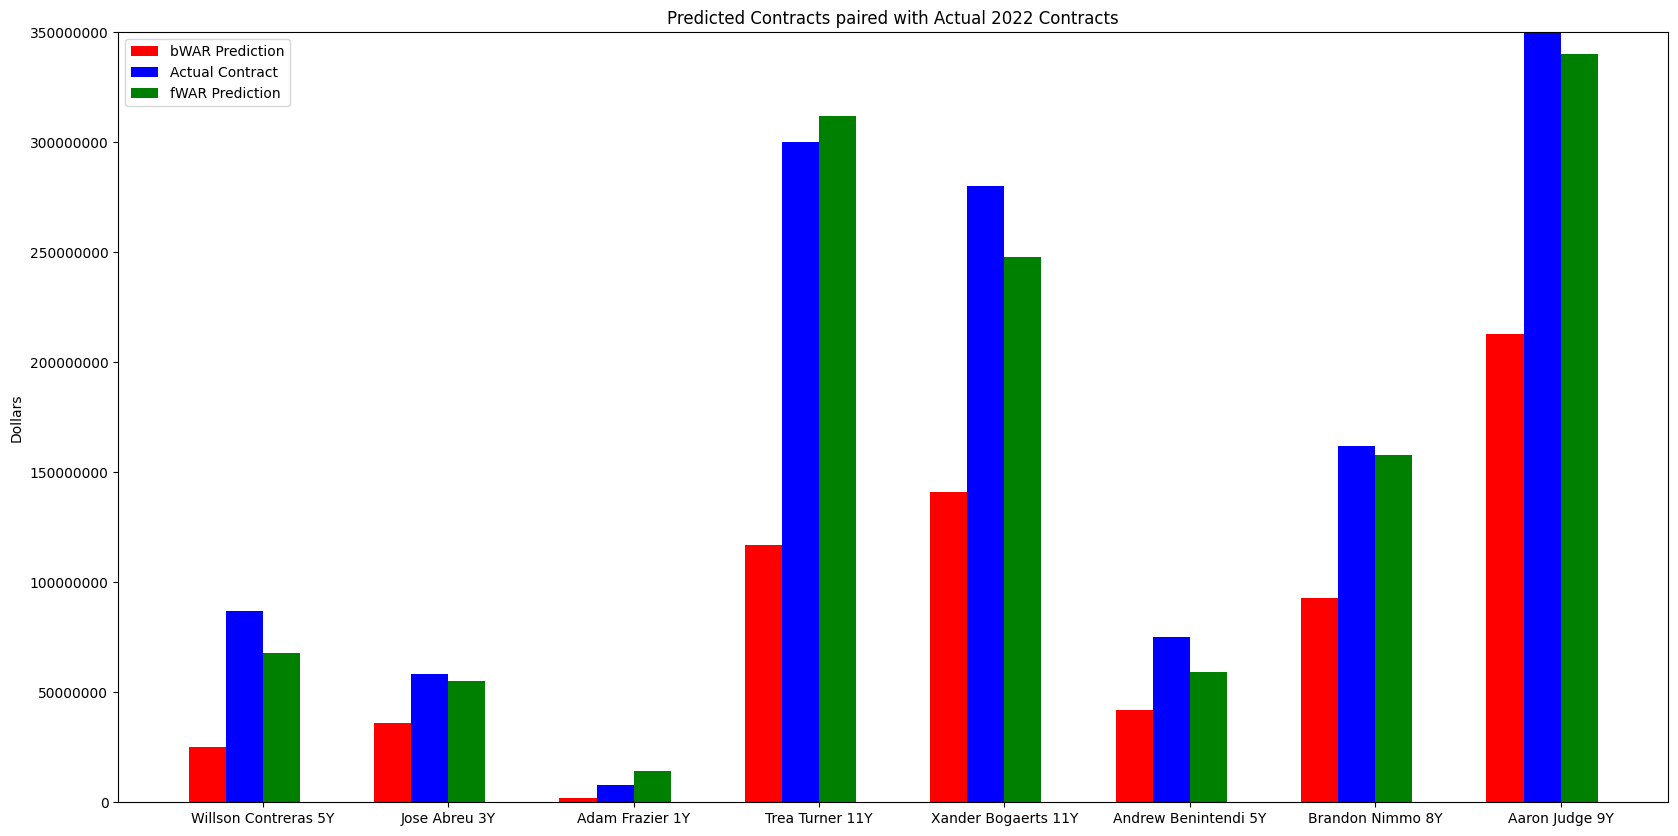

In [27]:
plt.figure(figsize=(20, 10))
X_axis = np.arange(len(names))

# plot the three results
plt.bar(X_axis-.3, predB, .2, label="bWAR Prediction", color='r')
plt.bar(X_axis-.1, real, .2, label="Actual Contract", color='b')
plt.bar(X_axis+.1, pred, .2, label="fWAR Prediction", color='g')


plt.title("Predicted Contracts paired with Actual 2022 Contracts")
plt.ylim(0,350000000)
plt.ticklabel_format(style="plain")
plt.ylabel("Dollars")
plt.xticks(X_axis, names)
plt.legend()
plt.show()

# Seeing how close the fWAR contracts were

In [28]:
# lets calculate how far away they were from each other

for i, row in enumerate(names):
    print(f'{row}: ')
    print(f'Actual: \t${int(real[i])}')
    print(f'Predicted: \t${int(pred[i])}')
    print(f'% Difference: \t{(1-real[i]/pred[i])*100:.2f}%')
    print()

Willson Contreras 5Y: 
Actual: 	$87000000
Predicted: 	$68000000
% Difference: 	-27.94%

Jose Abreu 3Y: 
Actual: 	$58500000
Predicted: 	$55000000
% Difference: 	-6.36%

Adam Frazier 1Y: 
Actual: 	$8000000
Predicted: 	$14000000
% Difference: 	42.86%

Trea Turner 11Y: 
Actual: 	$300000000
Predicted: 	$312000000
% Difference: 	3.85%

Xander Bogaerts 11Y: 
Actual: 	$280000000
Predicted: 	$248000000
% Difference: 	-12.90%

Andrew Benintendi 5Y: 
Actual: 	$75000000
Predicted: 	$59000000
% Difference: 	-27.12%

Brandon Nimmo 8Y: 
Actual: 	$162000000
Predicted: 	$158000000
% Difference: 	-2.53%

Aaron Judge 9Y: 
Actual: 	$360000000
Predicted: 	$340000000
% Difference: 	-5.88%



# THE END